In [1]:
from random import randint
from time import sleep
import os
import numpy as np
from openai import OpenAI
import pandas as pd
from twarc import Twarc2
import re
import copy
from spacy.lang.en import stop_words
from pysentimiento.preprocessing import preprocess_tweet
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

C:\Users\user\.conda\envs\chatgpt\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\user\.conda\envs\chatgpt\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
C:\Users\user\.conda\envs\chatgpt\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
data_root_dir_path = r"C:\Users\user\Datasets\Twitter"

## Load Twitter clean data containing tweets
Data was cleaned and pre-processed

In [3]:
# Dataset was oibtained from https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification/
tweets_file_name = os.path.join(data_root_dir_path, "Corona_NLP_train_clean.csv")
tweets_df = pd.read_csv(tweets_file_name, engine='python', encoding = "ISO-8859-1")
tweets_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,clean_post
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice Talk to your neighbours family to excha...
1,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,Coronavirus Australia: Woolwohs to give elderl...
2,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,My food stock is not the only one which is emp...
3,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Negative,"Me, ready to go at supermarket during the hash..."
4,3804,48756,"ÃÂT: 36.319708,-82.363649",16-03-2020,As news of the regionÃÂs first confirmed COV...,Positive,As news of the regions first confirmed COVID-1...


In [4]:
tweets_df["gpt_sentiment"] = None
tweets_df["gpt_emotion"] = None

## Set up the OpenAI API client

In [11]:
# Set up the OpenAI API client
api_key = ""  # OPENAI - API KEY
client = OpenAI(
    # This is the default and can be omitted
    api_key=api_key,
)

## Get sentiment of tweets from ChatGPT

In [70]:
# For the sake of the example, work on the first 10 tweets
tweets_small_df = copy.copy(tweets_df)
tweets_small_df = tweets_small_df.loc[0:100, :]

In [71]:
tweets_small_df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,clean_post,gpt_sentiment,gpt_emotion
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice Talk to your neighbours family to excha...,2,8
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,Coronavirus Australia: Woolwohs to give elderl...,1,None
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,My food stock is not the only one which is emp...,1,None
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Negative,"Me, ready to go at supermarket during the hash...",3,None
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,As news of the regionÂs first confirmed COVID...,Positive,As news of the regions first confirmed COVID-1...,2,None
...,...,...,...,...,...,...,...,...,...
96,3895,48847,"Washington, DC",16-03-2020,.@kroger is the biggest supermarket chain in t...,Positive,. is the biggest supermarket chain in the Unit...,None,None
97,3896,48848,"Washington, DC",16-03-2020,"@kroger Instead of paid sick leave, @kroger is...",Positive,"Instead of paid sick leave, is providing 2 we...",None,None
98,3897,48849,San Joaquin Valley CA,16-03-2020,I followed this when I went shopping a few day...,Positive,I followed this when I went shopping a few day...,None,None
99,3898,48850,Planet Earth,16-03-2020,@joncoopertweets I took these pictures today a...,Negative,I took these pictures today at my home grocery...,None,None


In [72]:
sentiments_dict = {1: "Positive", 2: "Neutral", 3: "Negative"}
def sentiment_prompt(text):
    # Add random delay to the function to avoid overload
    delay = randint(1, 3)
    sleep(delay)
    model_engine = "gpt-3.5-turbo"
    prompt = [{"role": "user",
               "content": "Is the sentiment of this tweet positive, neutral, or negative? Answer only with a number: 1 if {}, 2 if {}, and 3 if {}. Here is the text:".format(
                   sentiments_dict[1],
                   sentiments_dict[2],
                   sentiments_dict[3])
              },
              {"role": "user", "content": text}]
    
    # Generate a response
    chat_completion = client.chat.completions.create(
        messages=prompt,
        model="gpt-3.5-turbo",
        temperature=0.5,
        max_tokens=1024
    )
    
    response = chat_completion.choices[0].message.content
    return response

In [73]:
for i, row in tweets_small_df.iterrows():
    tweet_id = i
    try:
        tweets_small_df.loc[i,'gpt_sentiment'] =  sentiments_dict[int(sentiment_prompt(row.clean_post))]
        print(row.clean_post)
        print("Sentiment of tweet {} is **{}**".format(tweet_id, tweets_small_df.at[i,'gpt_sentiment']))
        print("===============================")
    except Exception as e:
        print("Somthing went wrong with tweet ID", tweet_id, e)

Sentiment of tweet 1 is **Neutral**
Sentiment of tweet 2 is **Positive**
Sentiment of tweet 3 is **Positive**
Sentiment of tweet 4 is **Negative**
Sentiment of tweet 5 is **Neutral**
Sentiment of tweet 6 is **Neutral**
Sentiment of tweet 7 is **Neutral**
Sentiment of tweet 8 is **Positive**
Sentiment of tweet 9 is **Positive**
Sentiment of tweet 10 is **Neutral**
Sentiment of tweet 11 is **Neutral**
Sentiment of tweet 12 is **Positive**
Sentiment of tweet 13 is **Neutral**
Sentiment of tweet 14 is **Positive**
Sentiment of tweet 15 is **Neutral**
Sentiment of tweet 17 is **Negative**
Sentiment of tweet 18 is **Neutral**
Sentiment of tweet 19 is **Positive**
Sentiment of tweet 20 is **Negative**
Sentiment of tweet 21 is **Neutral**
Sentiment of tweet 22 is **Positive**
Sentiment of tweet 23 is **Positive**
Sentiment of tweet 24 is **Negative**
Sentiment of tweet 25 is **Neutral**
Sentiment of tweet 26 is **Positive**
Sentiment of tweet 27 is **Positive**
Sentiment of tweet 28 is **Neutr

### Compare obtained sentiment from ChatGPT to that of manually annotated ("Sentiment" column)

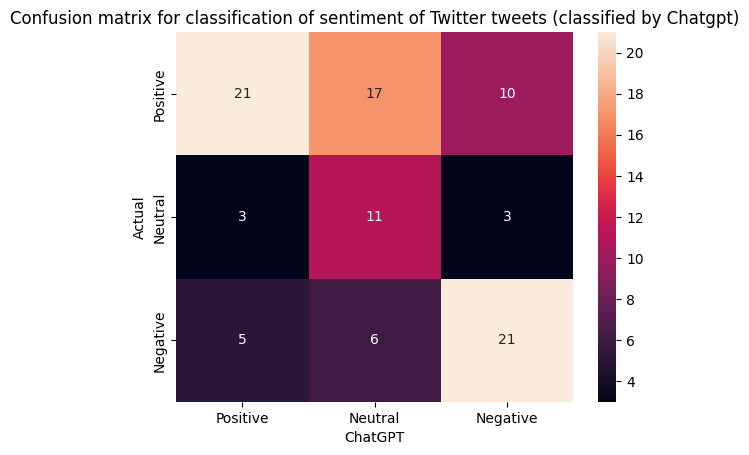

In [74]:
labels=["Positive", "Neutral", "Negative"]
cm = confusion_matrix(tweets_small_df["Sentiment"], tweets_small_df["gpt_sentiment"], labels=labels)
f = sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True, fmt='d')
f.set_ylabel("Actual")
f.set_xlabel("ChatGPT")
f.set_title("Confusion matrix for classification of sentiment of Twitter tweets (classified by Chatgpt)")
plt.show()

In [75]:
print("Accuracy of ChatGPT's sentiment classification on the dataset sample (size is {}) is: {}".format(tweets_small_df.shape[0],
                                                                                                        accuracy_score(tweets_small_df["Sentiment"],
                                                                                                                       tweets_small_df["gpt_sentiment"],
                                                                                                                       normalize=True)))

Accuracy of ChatGPT's sentiment classification on the dataset sample (size is 97) is: 0.5463917525773195


## Get emotion of tweets from ChatGPT (unsupervised)

In [76]:
emotions_dict = {1: "anger", 2: "joy", 3: "sarcasm", 4: "fear", 5: "surprise", 6: "sadness", 7: "disgust", 8: "neutral"}

def emotion_prompt(text):
    # Add random delay to the function to avoid overload
    delay = randint(1, 3)
    sleep(delay)

    model_engine = "gpt-3.5-turbo"
    prompt = [{"role": "user",
               "content": f"Which of these emotions - anger, joy, sarcasm, fear, surprise, sadness, disgust, neutral - best represents the mental state of the person writing the following tweet? Answer only with a number: 1 if {emotions_dict[1]}, 2 if {emotions_dict[2]}, 3 if {emotions_dict[3]}, 4 if {emotions_dict[4]}, 5 if {emotions_dict[5]}, 6 if {emotions_dict[6]}, 7 if {emotions_dict[7]}, 8 if {emotions_dict[8]}. Here is the text:"},
              {"role": "user", "content": text}]

    # Generate a response
    chat_completion = client.chat.completions.create(
        messages=prompt,
        model="gpt-3.5-turbo",
        temperature=0.5,
        max_tokens=1024
    )
    
    response = chat_completion.choices[0].message.content
    return response

In [77]:
for i, row in tweets_small_df.iterrows():
    tweet_id = i
    try:
        tweets_small_df.loc[i,'gpt_emotion'] = emotions_dict[int(emotion_prompt(row.clean_post))]
        print(row.clean_post)
        print("Emotion of tweet {} is **{}**".format(tweet_id, tweets_small_df.loc[i,'gpt_emotion']))
        print("===============================")
    except Exception as e:
        print("Somthing went wrong with tweet ID", tweet_id, e)

Emotion of tweet 1 is **neutral**
Emotion of tweet 2 is **neutral**
Emotion of tweet 3 is **neutral**
Emotion of tweet 4 is **neutral**
Emotion of tweet 5 is **neutral**
Emotion of tweet 6 is **sarcasm**
Emotion of tweet 7 is **neutral**
Emotion of tweet 8 is **neutral**
Emotion of tweet 9 is **neutral**
Emotion of tweet 10 is **neutral**
Emotion of tweet 11 is **neutral**
Emotion of tweet 12 is **joy**
Emotion of tweet 13 is **neutral**
Emotion of tweet 14 is **neutral**
Emotion of tweet 15 is **neutral**
Emotion of tweet 17 is **neutral**
Emotion of tweet 18 is **neutral**
Emotion of tweet 19 is **neutral**
Emotion of tweet 20 is **anger**
Emotion of tweet 21 is **neutral**
Emotion of tweet 22 is **joy**
Emotion of tweet 23 is **joy**
Emotion of tweet 24 is **anger**
Emotion of tweet 25 is **neutral**
Emotion of tweet 26 is **neutral**
Emotion of tweet 27 is **neutral**
Emotion of tweet 28 is **neutral**
Emotion of tweet 29 is **fear**
Emotion of tweet 30 is **neutral**
Emotion of tw

### Get distribution of emotions in dataset (according to ChatGPT's answers)

Text(0.5, 1.0, 'Distibution of emotion classes (classified by Chatgpt)')

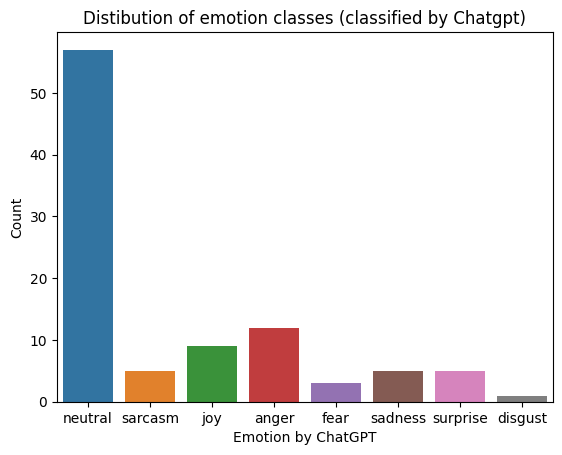

In [78]:
s = sns.countplot(tweets_small_df, x="gpt_emotion")
s.set_xlabel("Emotion by ChatGPT")
s.set_ylabel("Count")
s.set_title("Distibution of emotion classes (classified by Chatgpt)")

## Get discourse topic using ChatGPT (unsupervised)

In [106]:
def get_topics_prompt(texts):
    # Add random delay to the function to avoid overload
    delay = randint(1, 5)
    sleep(delay)

    model_engine = "gpt-3.5-turbo"

    prompt = [{"role": "user",
               "content": "What are the main three topics discussed in the following Twitter tweets? Write three topic titles."
               "The tweet are:"},
              {"role": "user", "content": texts}]

    # Generate a response
    chat_completion = client.chat.completions.create(
        messages=prompt,
        model="gpt-3.5-turbo",
        temperature=0.6,
        max_tokens=1024
    )

    response = chat_completion.choices[0].message.content
    return response

In [107]:
all_tweets = tweets_small_df.loc[0:50, :]["clean_post"]
try:
    induced_topics = get_topics_prompt("; ".join(list(all_tweets)))
    print("The 3 main topics discussed in the tweets regarding COVID-19 are:\n")
    print(induced_topics)
except Exception as e:
    print("Somthing went wrong with tweet ID", tweet_id, e)

The 3 main topics discussed in the tweets regarding COVID-19 are:

1. COVID-19 Outbreak and Panic Buying:
- Panic buying and stock shortages due to COVID-19
- Encouraging people to not panic and only buy what they need
- Retail store closures and restrictions due to the outbreak

2. Online Shopping and Payment Methods:
- Using online shopping and payment methods to prevent the spread of the virus
- Increased demand for online orders and potential delays
- Impact of COVID-19 on consumer shopping behavior

3. Community Support and Assistance:
- Helping neighbors and vulnerable individuals during the outbreak
- Donating to food banks and nonprofits to support those impacted by COVID-19
- Providing free deliveries of essential goods to elderly individuals in need.


### Categorize tweets into topics using Chatgpt (based on inferred topic list above)

In [108]:
def classify_prompt(text):
    # Add random delay to the function to avoid overload
    delay = randint(1, 3)
    sleep(delay)

    model_engine = "gpt-3.5-turbo"

    prompt = [{"role": "user", "content": "Which one of this topics best describes the following tweet? Answer only with the topic number. \
               1. Topic 1: COVID-19 Outbreak and Panic Buying. \
               2. Topic 2: Online Shopping and Payment Methods. \
               3. Topic 3: Community Support and Assistance. \
               If none of the topics is suitable, write the word 'DIFFERENT'. \
               The tweet:"},
              {"role": "user", "content": text}]

    # Generate a response
    chat_completion = client.chat.completions.create(
        messages=prompt,
        model="gpt-3.5-turbo",
        temperature=0.6,
        max_tokens=1024
    )

    response = chat_completion.choices[0].message.content
    return response

In [109]:
# Classify a batch of 50 tweets to one of the topics in the list of 3 inferred topics based on a batch of different 50 tweets.
# Due to a limit in the prompts length of ChatGPT's API, only 50 tweets could be sent to the chat.
test_tweets = tweets_small_df.loc[50:, :]
test_tweets["gpt_classify"] = None
topics_dict = {1: "Topic 1: COVID-19 Outbreak and Panic Buying.",
               2: "Topic 2: Online Shopping and Payment Methods.",
               3: "Topic 3: Community Support and Assistance."
              }

for i, row in test_tweets.iterrows():
    tweet_id = i
    try:
        response = classify_prompt(row.clean_post)
        test_tweets.loc[i,'gpt_classify'] = topics_dict[int(response.split(".")[0])]
        print(row.clean_post)
        print("Topic of tweet {} is **{}**".format(tweet_id, test_tweets.loc[i,'gpt_classify']))
        print("===============================")
    except Exception as e:
        print("Somthing went wrong with tweet ID", tweet_id, e)

C:\Users\user\AppData\Local\Temp\ipykernel_16408\3028225731.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_tweets["gpt_classify"] = None


Topic of tweet 50 is **Topic 1: COVID-19 Outbreak and Panic Buying.**
Topic of tweet 51 is **Topic 3: Community Support and Assistance.**
Topic of tweet 52 is **Topic 3: Community Support and Assistance.**
Topic of tweet 53 is **Topic 2: Online Shopping and Payment Methods.**
Topic of tweet 54 is **Topic 1: COVID-19 Outbreak and Panic Buying.**
Topic of tweet 55 is **Topic 3: Community Support and Assistance.**
Topic of tweet 56 is **Topic 1: COVID-19 Outbreak and Panic Buying.**
Topic of tweet 57 is **Topic 3: Community Support and Assistance.**
Topic of tweet 58 is **Topic 1: COVID-19 Outbreak and Panic Buying.**
Topic of tweet 59 is **Topic 1: COVID-19 Outbreak and Panic Buying.**
Topic of tweet 60 is **Topic 1: COVID-19 Outbreak and Panic Buying.**
Topic of tweet 62 is **Topic 1: COVID-19 Outbreak and Panic Buying.**
Topic of tweet 63 is **Topic 2: Online Shopping and Payment Methods.**
Topic of tweet 64 is **Topic 2: Online Shopping and Payment Methods.**
Topic of tweet 65 is **To

The 3 main topics discussed in the tweets regarding COVID-19 are:

1. COVID-19 Outbreak and Panic Buying:
- Panic buying and stock shortages due to COVID-19
- Encouraging people to not panic and only buy what they need
- Retail store closures and restrictions due to the outbreak

2. Online Shopping and Payment Methods:
- Using online shopping and payment methods to prevent the spread of the virus
- Increased demand for online orders and potential delays
- Impact of COVID-19 on consumer shopping behavior

3. Community Support and Assistance:
- Helping neighbors and vulnerable individuals during the outbreak
- Donating to food banks and nonprofits to support those impacted by COVID-19
- Providing free deliveries of essential goods to elderly individuals in need.


C:\Users\user\AppData\Local\Temp\ipykernel_16408\2412677237.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_tweets["topic_number"] = test_tweets["gpt_classify"].apply(lambda x: x.split(":")[0] if ":" in str(x) else None)


Text(0.5, 1.0, 'Distibution of discourse topics (classified by Chatgpt)')

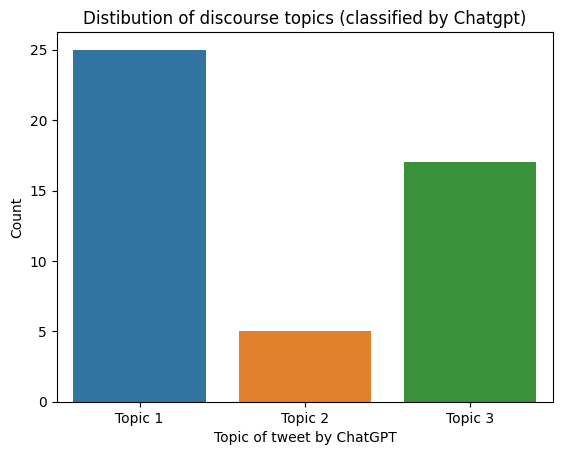

In [111]:
test_tweets["topic_number"] = test_tweets["gpt_classify"].apply(lambda x: x.split(":")[0] if ":" in str(x) else None)
print("The 3 main topics discussed in the tweets regarding COVID-19 are:\n")
print(induced_topics)
print("=========================")
s = sns.countplot(test_tweets.sort_values(by="topic_number"), x="topic_number")
s.set_xlabel("Topic of tweet by ChatGPT")
s.set_ylabel("Count")
s.set_title("Distibution of discourse topics (classified by Chatgpt)")

## Save result dataset

In [ ]:
tweets_small_df.to_csv(os.path.join(data_root_dir_path, "./tweets_with_sentiment_emotion.csv"))
test_tweets.to_csv(os.path.join(data_root_dir_path, "./test_tweets_with_topics.csv"))
print("Finished!")